# Predicting mode choice behavior based on person characteristics

Members & Student numbers: Willemijn ten Voorden (6101275), Frederiek Backers (4704452), Annerieke Ohm (4852990), Nikolaos Tsironis (6008712)

# Research Objective
This research proposal is made for the TIL Programming TIL6022 course project. We focus on an application project on mobility trends in The Netherlands using open-source data, making this a societal project. We were inspired by the current discussions on introducing rush hour tax for train tickets in the Netherlands [1]. Looking at the discussion, we were wondering if there are certain personal characteristics that can be related to mode choice behavior. This resulted in the following research question:

**How do personal characteristics influence mode choice behaviour of adult travellers in The Netherlands during the years 2018-2022?**

To answer this research question we will do some data processing, quantitative analysis and visualize our results. To be able to answer our research question, we present some subquestions:

1. *What is the probability for a person to choose a certain transport mode based on one personal characteristic?*
2. *From the previous subquestion, which personal characteristics jump out and could be researched further?*
3. *Is there a significant difference over the years in mode choice?*
4. *Can we use machine learning methods to classify which personal characteristics correlate the most with the various modes?*


For every subquestion we do the following quantitative analysis and visualisations:
1. Use probability theory, make plots and interpret results.
2. Make (interactive) plots for various personal charactertics and elaborate on the results.
3. .....
4. We use K-means clustering to cluster the data into k clusters. The number of clusters k is determined by using the Elbow method and checking the BIC, Silhouette and Davies scores. Then we cluster the data and check the correlation between the clusters and the mode choices, and check which personal characteristics belong to which cluster.

The data is obtained from CBS (Central Bureau for Statistics Netherlands) that includes mode choice and personal characteristics of individuals. The data will be explained more thoroughly in the data section.

# Contribution Statement

*Be specific. Some of the tasks can be coding (expect everyone to do this), background research, conceptualisation, visualisation, data analysis, data modelling*

**Willemijn**:

**Nick**:

**Annerieke**:

**Frederiek**:

# Data Used

For this research project we use one dataset obtained from CBS that includes mode choice and personal characteristics of individuals:

*StatLine - Mobiliteit; per persoon, persoonskenmerken, vervoerwijzen en regio's (cbs.nl)* [2]

The dataset contains information about the travel behavior of the Dutch population aged 6 and older in private households, excluding residents of institutions and homes. The data includes the number of trips, distance traveled and average travel duration per person, per day and per year. It covers regular movements within the Netherlands, including domestic vacation mobility. Series movements are not considered regular movements. The data from years 2018-2022 is used.

Travel behavior is broken down into personal characteristics, modes of transportation, population, gender and regions. To slim the dataset this study only focuses on the average number of trips for every mode per day, for every person characteristic. We use only certain personal characteristics such as income, migration background, education level, participation and availability of a student PT card and drivers license, next to gender and age. Some other scale limitations are:
- Geographical boundary: the Netherlands
- Travel modes: car, public transport, active modes and other modes
- Time scale: 2018-2022
- Ages: 18 years and older



# Midterm check comment for reader!
We still need to fix the lay-out of the report and make it a clear readable story, and we still need to elaborate on some methods and results but we will do that later. However, we have done quite some analysis and visualisations that we would like to get feedback on :).

# Data Pipeline

## Import packages

In [2]:
import os
import pandas as pd
%matplotlib inline
import pandas as pd
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

# packages for machine learning method k-means clustering
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture

## Import data

In [3]:
file_path = os.getcwd() + '\Data.csv'

# read data: remove first 6 rows and last row that do not contain data
data = pd.read_csv(file_path, delimiter = ';', skiprows = 6, skipfooter = 1, engine = 'python')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nicktsironis/Documents/GitHub/TIL6022Project\\Data.csv'

## Data processing

In [8]:
# make person characteristics index
data.set_index('Vervoerwijzen', inplace = True)

# remove rows with missing information
data_updated = data.drop(labels = ["Persoonskenmerken", "Totaal personen", "Leeftijd:6 tot 12 jaar", "Leeftijd: 12 tot 18 jaar", 
                                       "Participatie: werkloos", "Participatie:  arbeidsongeschikt", "Geen rijbewijs; jonger dan 17 jaar", "OV-Studentenkaart: weekendabonnement"])

# replace dots in dataset with 0
data_updated = data_updated.replace('.', 0)

# only keep columns with average number of movements per day per person
columns_to_keep = [col for col in data_updated.columns if data_updated.loc["Onderwerp", col] == "Gemiddeld per persoon per dag |Verplaatsingen "]
data_updated = data_updated[columns_to_keep]

#Remove the "onderwerp" row, since this is now the same for all columns
data_updated = data_updated.drop("Onderwerp")

# the data is formatted as strings, we convert these to floats and make NaN's equal to 0 for all three dataframes
def preprocess_dataframe(df):
    # Convert strings to floats and replace NaN values with 0
    df = df.apply(lambda col: col.str.replace(',', '.').astype(float).fillna(0))
    return df

data_updated = preprocess_dataframe(data_updated)

#Merge the rows "Leeftijd: 65 tot 75 jaar" en "75jaar of ouder" into one row
data_updated = (data_updated.reset_index()
                .replace({"Vervoerwijzen": {"Leeftijd: 75 jaar of ouder" : "Leeftijd: 65 tot 75 jaar"}})
                .groupby("Vervoerwijzen", sort=False).sum()
)
data_updated = data_updated.rename({"Leeftijd: 65 tot 75 jaar" : "Leeftijd: 65 jaar of ouder"})

#Split dataframe into 5 separate datframes: one for each year and remove row "perioden"
columns_2018 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2018]
columns_2019 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2019]
columns_2020 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2020]
columns_2021 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2021]
columns_2022 = [col for col in data_updated.columns if int(data_updated.loc["Perioden", col]) == 2022]
transport_2018 = data_updated[columns_2018].drop("Perioden")
transport_2019 = data_updated[columns_2019].drop("Perioden")
transport_2020 = data_updated[columns_2020].drop("Perioden")
transport_2021 = data_updated[columns_2021].drop("Perioden")
transport_2022 = data_updated[columns_2022].drop("Perioden")

#Merge car driver and passenger into car, cycle and walk into active modes and trainand bus/tram/metro into public transport
def merge_transport_categories(df):
    #The different years have a number behind the column names. Remove these numbers.
    column_names = ["Total", "Personenauto (bestuurder)", "Personenauto  (passagier)", 
                    "Trein", "Bus/tram/metro", "Fiets", "Lopen", "Overige vervoerwijze"]
    df.columns = column_names
    #Merge desired columns
    df["Passengercar"] = df["Personenauto (bestuurder)"] + df["Personenauto  (passagier)"]
    df["Public Transport"] = df["Trein"] + df["Bus/tram/metro"]
    df["Active modes"] = df["Fiets"] + df["Lopen"]
    df = df.drop(columns = ["Personenauto (bestuurder)", "Personenauto  (passagier)", "Trein", "Bus/tram/metro", "Fiets", "Lopen"])
    #Move "Overige vervoerswijze" to the end of the dataframe
    Other = df.pop("Overige vervoerwijze")
    df["Other modes"] = Other
    #Translate all index names to English
    index_names = ["Age: 18 to 25 years", "Age: 25 to 35 years", "Age: 35 to 50 years", "Age: 50 to 65 years", 
                   "Age: 65 years or older", "Migrationbackground: The Netherlands", "Migrationbackground: Western", 
                   "Migrationbackground: Non-western", "Standardised income: 1st 20% group", "Standardised income: 2nd 20% group",
                   "Standardised income: 3rd 20% group", "Standardised income: 4th 20% group", 
                   "Standardised income: 5th 20% group", "PT-studentcard: Weekday subscription", "PT-studentcard: None",
                   "Education level: Low", "Education level: middle", "Education level: High", "Participation: Working 12 to 30 h/w",
                   "Participation: Working 30+ h/w", "Participation: student", "Participation: retired",
                   "Participation: Other", "Drivers licence; owns own car", "Drivers license; car in household",
                   "Drivers license; no car", "No drivers license"]
    df.index = index_names

    return df

transport_2018 = merge_transport_categories(transport_2018)
transport_2019 = merge_transport_categories(transport_2019)
transport_2020 = merge_transport_categories(transport_2020)
transport_2021 = merge_transport_categories(transport_2021)
transport_2022 = merge_transport_categories(transport_2022)

AttributeError: 'dict' object has no attribute 'set_index'

In [9]:
#Example of what a dataset now looks like. Layout the same for all years, only numbers might differ.
transport_2018

NameError: name 'transport_2018' is not defined

# Data analysis

Write small introduction here.

### Subquestion 1: What is the probability for a person to choose a certain transport mode based on one personal characteristic?
To answer this question, the data is normalised per personal characteristic. This way, the numbers in the dataset become independent of how much a certain group travels and instead shows the distribution of the group's travels over the different modes. This is then visualised using stacked barplots, allowing for comparison between the different groups. This is done for each year separately, allowing for both comaprison within one year as well as comparison between the different years.

In [5]:
#Normalise dataframe rows
def normal_rows(df):
    normal_df = df.drop(columns = ["Total"])
    normal_df = normal_df.div(normal_df.sum(axis = 1), axis = 0)
    return normal_df

normal_2018 = normal_rows(transport_2018)
normal_2019 = normal_rows(transport_2019)
normal_2020 = normal_rows(transport_2020)
normal_2021 = normal_rows(transport_2021)
normal_2022 = normal_rows(transport_2022)

normal_2018

Passengercar  Public Transport  \
Age: 18 to 25 years                       0.383212          0.160584   
Age: 25 to 35 years                       0.510067          0.080537   
Age: 35 to 50 years                       0.534375          0.040625   
Age: 50 to 65 years                       0.517857          0.039286   
Age: 65 years or older                    0.457921          0.029703   
Migrationbackground: The Netherlands      0.475862          0.041379   
Migrationbackground: Western              0.422481          0.077519   
Migrationbackground: Non-western          0.367713          0.139013   
Standardised income: 1st 20% group        0.323770          0.090164   
Standardised income: 2nd 20% group        0.433198          0.056680   
Standardised income: 3rd 20% group        0.466899          0.048780   
Standardised income: 4th 20% group        0.493377          0.046358   
Standardised income: 5th 20% group        0.521595          0.049834   
PT-studentcard: Weekday subscription      0.289855          0.289855   
PT-studentcard: None                      0.469314          0.043321   
Education level: Low                      0.421525          0.049327   
Education level: middle                   0.510274          0.061644   
Education level: High                     0.501608          0.064309   
Participation: Working 12 to 30 h/w       0.505988          0.041916   
Participation: Working 30+ h/w            0.561873          0.056856   
Participation: student                    0.265734          0.090909   
Participation: retired                    0.469484          0.028169   
Participation: Other                      0.444444          0.035714   
Drivers licence; owns own car             0.619377          0.020761   
Drivers license; car in household         0.530000          0.046667   
Drivers license; no car                   0.200000          0.140351   
No drivers license                        0.202830          0.150943   

                                      Active modes  Other modes  
Age: 18 to 25 years                       0.408759     0.047445  
Age: 25 to 35 years                       0.369128     0.040268  
Age: 35 to 50 years                       0.381250     0.043750  
Age: 50 to 65 years                       0.400000     0.042857  
Age: 65 years or older                    0.480198     0.032178  
Migrationbackground: The Netherlands      0.441379     0.041379  
Migrationbackground: Western              0.468992     0.031008  
Migrationbackground: Non-western          0.461883     0.031390  
Standardised income: 1st 20% group        0.545082     0.040984  
Standardised income: 2nd 20% group        0.469636     0.040486  
Standardised income: 3rd 20% group        0.442509     0.041812  
Standardised income: 4th 20% group        0.420530     0.039735  
Standardised income: 5th 20% group        0.395349     0.033223  
PT-studentcard: Weekday subscription      0.387681     0.032609  
PT-studentcard: None                      0.447653     0.039711  
Education level: Low                      0.466368     0.062780  
Education level: middle                   0.376712     0.051370  
Education level: High                     0.414791     0.019293  
Participation: Working 12 to 30 h/w       0.431138     0.020958  
Participation: Working 30+ h/w            0.327759     0.053512  
Participation: student                    0.615385     0.027972  
Participation: retired                    0.478873     0.023474  
Participation: Other                      0.480159     0.039683  
Drivers licence; owns own car             0.321799     0.038062  
Drivers license; car in household         0.383333     0.040000  
Drivers license; no car                   0.585965     0.073684  
No drivers license                        0.603774     0.042453

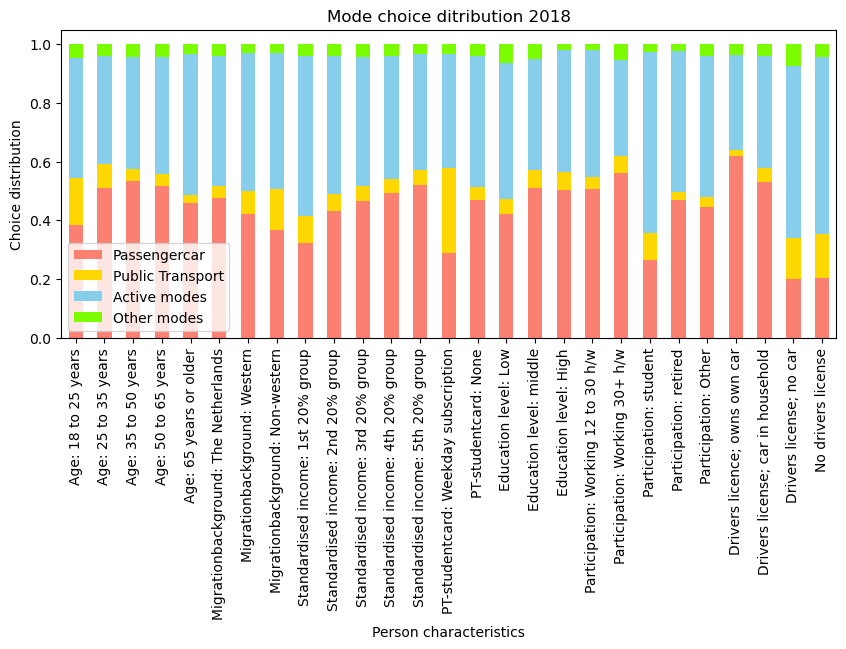

In [6]:
normal_2018.plot(kind = "bar", stacked = True, color = ["salmon", "gold", "skyblue", "lawngreen"], 
                  figsize = (10,4), fontsize = 10)
plt.title("Mode choice ditribution 2018")
plt.xlabel("Person characteristics")
plt.ylabel("Choice distribution")
plt.show()

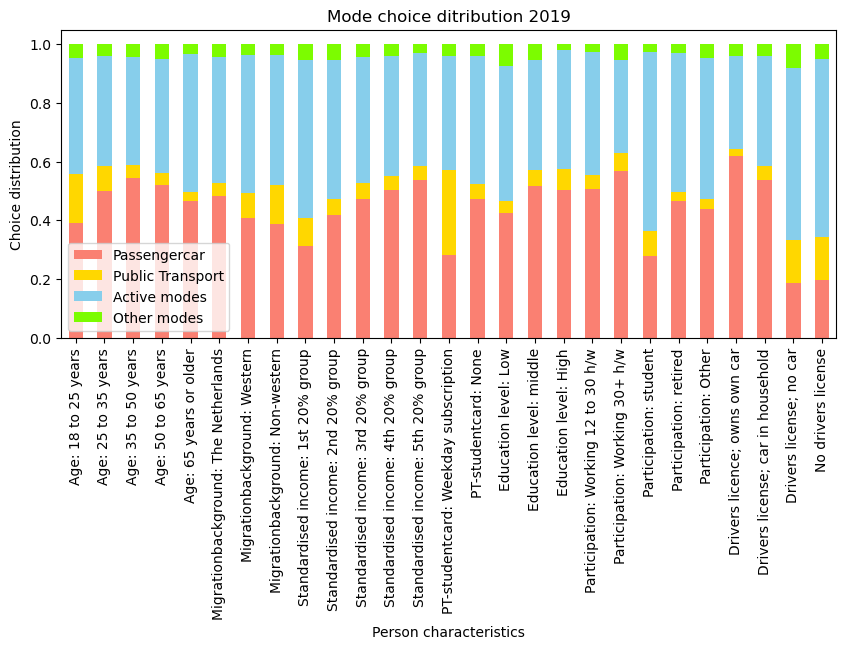

In [7]:
normal_2019.plot(kind = "bar", stacked = True, color = ["salmon", "gold", "skyblue", "lawngreen"], 
                  figsize = (10,4), fontsize = 10)
plt.title("Mode choice ditribution 2019")
plt.xlabel("Person characteristics")
plt.ylabel("Choice distribution")
plt.show()

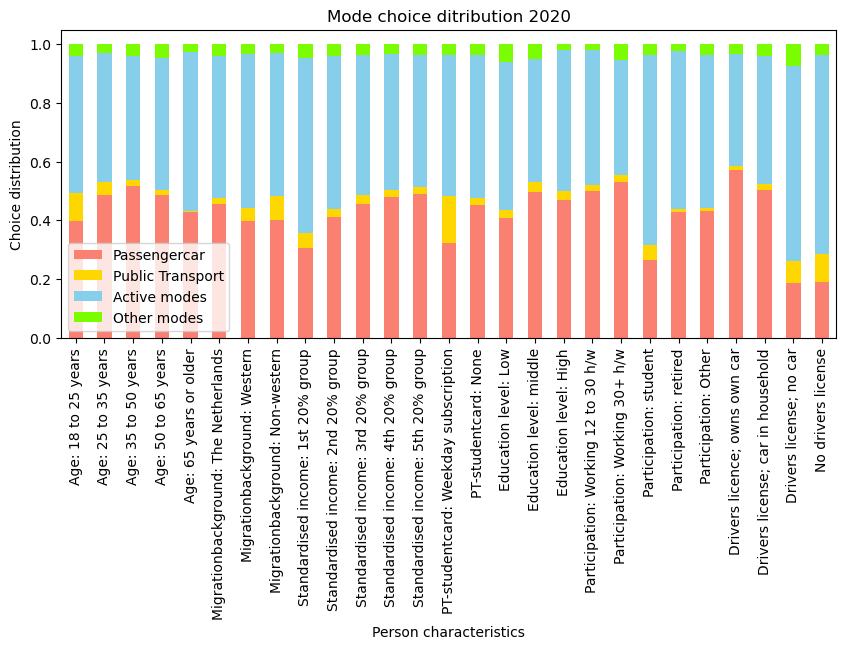

In [8]:
normal_2020.plot(kind = "bar", stacked = True, color = ["salmon", "gold", "skyblue", "lawngreen"], 
                  figsize = (10,4), fontsize = 10)
plt.title("Mode choice ditribution 2020")
plt.xlabel("Person characteristics")
plt.ylabel("Choice distribution")
plt.show()

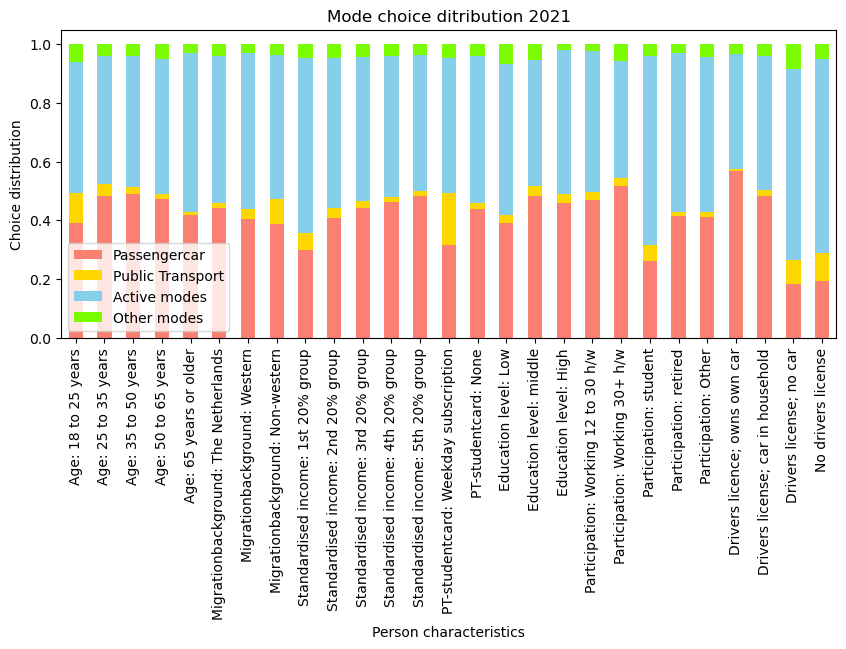

In [9]:
normal_2021.plot(kind = "bar", stacked = True, color = ["salmon", "gold", "skyblue", "lawngreen"], 
                  figsize = (10,4), fontsize = 10)
plt.title("Mode choice ditribution 2021")
plt.xlabel("Person characteristics")
plt.ylabel("Choice distribution")
plt.show()

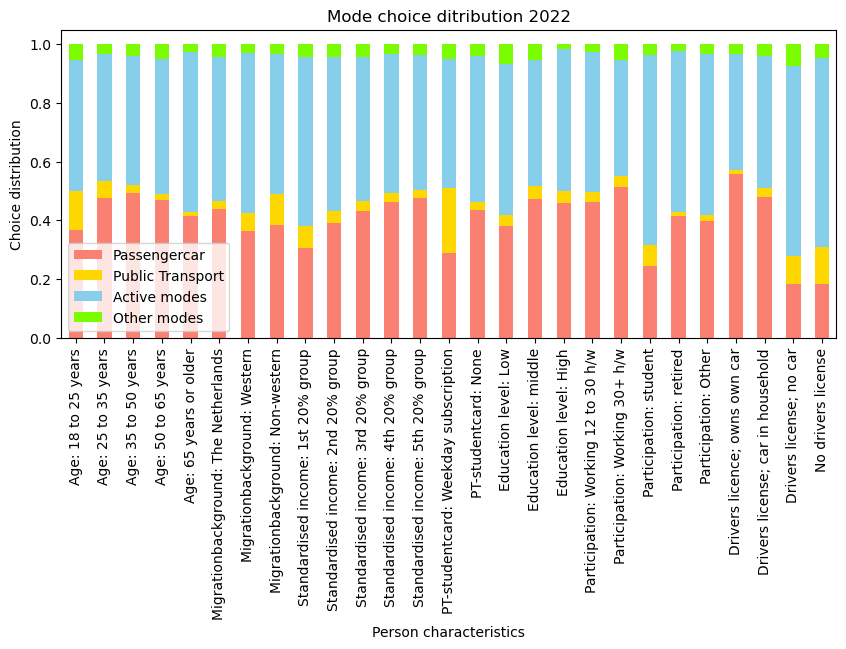

In [10]:
normal_2022.plot(kind = "bar", stacked = True, color = ["salmon", "gold", "skyblue", "lawngreen"], 
                  figsize = (10,4), fontsize = 10)
plt.title("Mode choice ditribution 2022")
plt.xlabel("Person characteristics")
plt.ylabel("Choice distribution")
plt.show()

Some things that immediately jump out based on these plots:
- The group with a PT-studentcard is using much more public transport than any other group.
- Movements by car seem to often be replaced by active modes for (on average) lower-income groups (low income, students, peopple with a migration background).
- There doesn't seem to be much difference between having a drivers license, but no car and not having a drivers license at all.
- The share of public transport during the covid years (2020, 2021) doesn't decrease as much as one might expect.

These and other points and possible explanations for them, will be research later in this report.

### Subquestion 2: From the previous subquestion, which personal characteristics jump out and could be researched further?

Some small introduction and an explanation on why we choose these four characteristics:

Age groups
Income groups
Public transport vs. car ownership vs. neither
Migration background

#### Age groups
How does the use of public transport vary by age?

In [6]:
import pandas as pd
import plotly.express as px

# Create a subset of the processed DataFrame containing the first five rows
subset_df = df.iloc[:5, :]

# Define the desired age group labels
age_groups = [
    "Age: 18 to 25 years",
    "Age: 25 to 35 years",
    "Age: 35 to 50 years",
    "Age: 50 to 65 years",
    "Age: 65 years or older",
]

# Create a new DataFrame with the specified age group labels
plot_df = pd.DataFrame({
    "Age Group": age_groups,
    "Passenger Car": subset_df["Passenger Car"],
    "Public Transport": subset_df["Public Transport"],
    "Active Modes": subset_df["Active Modes"],
    "Other Modes": subset_df["Other Modes"]
})

# Create an interactive bar chart with custom colors using the new data
fig = px.bar(
    plot_df,
    x="Age Group",
    y=["Passenger Car", "Public Transport", "Active Modes", "Other Modes"],
    title="Modes of Transportation by Age Group",
    labels={"value": "Transportation Preference", "Age Group": "Age Group"},
    color_discrete_map={
        "Passenger Car": "salmon",
        "Public Transport": "gold",
        "Active Modes": "skyblue",
        "Other Modes": "lawngreen",
    }
)

# Customize the appearance
fig.update_layout(xaxis_title="Age Group", yaxis_title="Values")
fig.update_traces(marker_line_color="black", marker_line_width=1.5, opacity=0.7)

# Display the interactive plot
fig.show()

Elaborating on the insights derived from the chart:

Age Group Preferences: The chart effectively illustrates that transportation preferences are not uniform across all age groups. Specific cohorts exhibit distinct inclinations toward different transportation options. Here are the key points related to age group preferences:

Active Modes: Among the age groups examined, the younger generations, particularly those aged 18 to 25 years and 25 to 35 years, display a pronounced preference for "Active Modes." This category includes transportation methods such as cycling and walking. The higher usage of these active modes suggests that younger individuals are more inclined toward physical activity and environmentally friendly transportation options.

Passenger Car: In contrast, older age groups, specifically those aged 50 to 65 years and 65 years or older, favor "Passenger Car" as their primary mode of transportation. This preference aligns with factors such as family responsibilities, the need for more spacious and convenient transportation, and potential mobility limitations that may come with age.

Transportation Mode Trends: The chart not only highlights the disparities in preferences among age groups but also reveals trends in transportation choices as individuals age:

Youthful Preference for Active Modes: The chart emphasizes that younger individuals have a natural inclination toward active modes, particularly cycling and walking. This can be attributed to several factors, including a desire for physical fitness, environmental consciousness, and the appeal of cost-effective transportation.

Shift Towards Passenger Cars with Age: As individuals progress through different life stages and age categories, they exhibit a shift in their transportation choices. The data demonstrates that older age groups exhibit a noticeable preference for "Passenger Car." This shift could be due to factors like increased familial responsibilities, the need for more comfortable and spacious transportation, or reduced physical mobility. Older individuals might also have a greater reliance on cars for various daily activities.

#### Public transport vs. car ownership vs. neither


#### Income groups
Does the choice of transport mode differ between income groups?

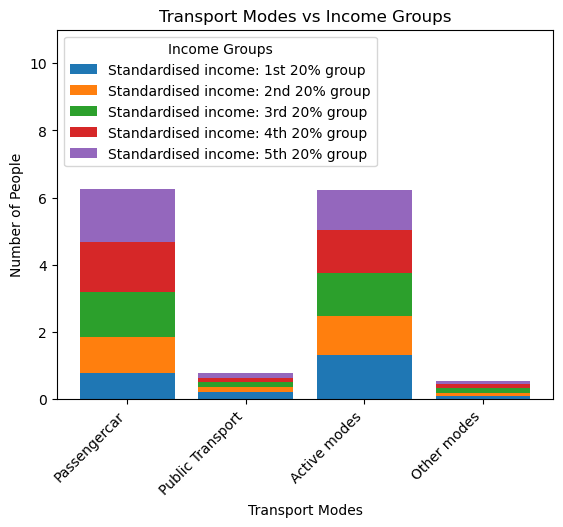

In [13]:
# Pivot the DataFrame to reshape the data for the stacked bar plot
transport_2018_1 = transport_2018.T  # Transpose the DataFrame

income_groups = [
    "Standardised income: 1st 20% group",
    "Standardised income: 2nd 20% group",
    "Standardised income: 3rd 20% group",
    "Standardised income: 4th 20% group",
    "Standardised income: 5th 20% group"
]

# Remove the 'Total' row from the DataFrame
transport_2018_2 = transport_2018_1.drop("Total", errors="ignore")

# Select the relevant income groups
data_to_plot = transport_2018_2[income_groups]

# Create an array of income group labels
income_group_labels = data_to_plot.columns

# Create a stacked bar plot
plt.bar(data_to_plot.index, data_to_plot[income_group_labels[0]], label=income_group_labels[0])
bottom = data_to_plot[income_group_labels[0]]

for i in range(1, len(income_group_labels)):
    plt.bar(data_to_plot.index, data_to_plot[income_group_labels[i]], label=income_group_labels[i], bottom=bottom)
    bottom += data_to_plot[income_group_labels[i]]

# Add labels and legend
plt.xlabel('Transport Modes')
plt.ylabel('Number of People')
plt.title('Transport Modes vs Income Groups')
plt.legend(loc='upper left', title='Income Groups')

# Customize the y-axis
plt.ylim(0, 11) 

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.show()

This plot shows the share that the five income groups have per transport mode. By looking at this plot, you can see that the 4th & 5th income group have a the highest share in car transport and is the 1st income group significantly smaller than the other income groups.

This significant difference is however not visible with any of the other tranport modes. Public transport & other modes have too small of a share to truly see the difference, but the 1st & 2nd income groups use the public transport mode more otften than the higher income groups.

#### Public transport vs. car ownership vs neither

#### Migration background

### Subquestion 3: Is there a significant difference over the years in mode choice?

## Conclusion

### Subquestion 4: Can we use machine learning methods to classify which personal characteristics correlate the most with the various modes?
We start by using the normalized data from the previous subquestion, then we show a correlation plot of the to get a better understanding of the relationship between the different modes based on the personal characteristics data. Next, we determine the number of clusters to make by using the elbow method and calculating the BIC, Silhouette and Davies score for different number of clusters. Based on these results we decide on the number of clusters k, which we then use to make k clusters using the k-means clustering machine learning technique. To anwer this subquestion the results are visualized and discussed. 

We now do this only for the 2018 data. We still need to decide to also do it for the other years, but looking at subquestion two there does not seem to be large changes through the years, but this still needs to be elaborated. 

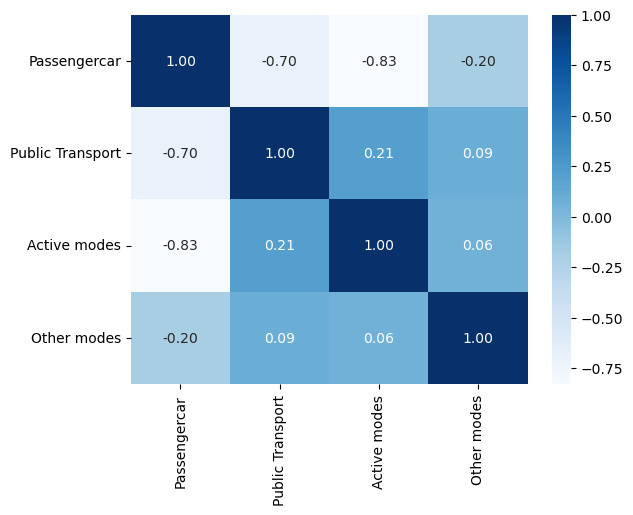

In [14]:
# Correlation plot of mode choices
fig, axes = plt.subplots(1)
corr_2018 = normal_2018.corr()
heatmap_2018 = sns.heatmap(round(corr_2018, 2), annot=True, cmap='Blues', ax=axes, fmt='.2f')

Something here about the correlation heatmap plot and what we can see.

#### K-means clustering

C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



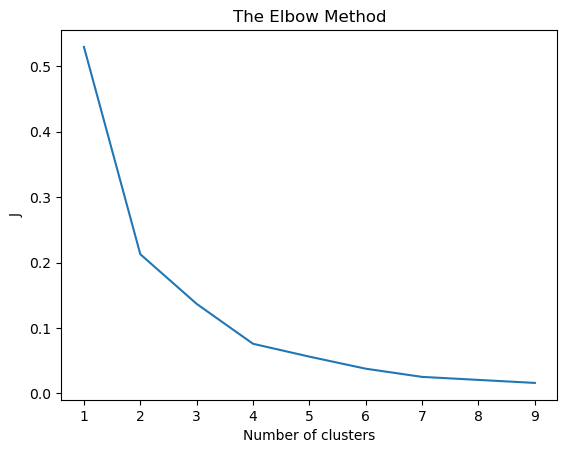

In [15]:
# elbow method to determine number of clusters
wcss = []
N_max = 10
for i in range(1, N_max):
    kmeans = KMeans(n_clusters=i,random_state=1).fit(normal_2018)
    wcss.append(kmeans.inertia_)
    
plt.figure()
plt.plot(range(1, N_max),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('J')
plt.show()

The rule of thumb for the elbow method is to choose the number of clusters where there is a kink in the graph. In this case there is a kink at k = 2, a small kink at k = 3 and large one at k = 4. To be able to make a better choice we also look at some scores to determine the number of clusters.

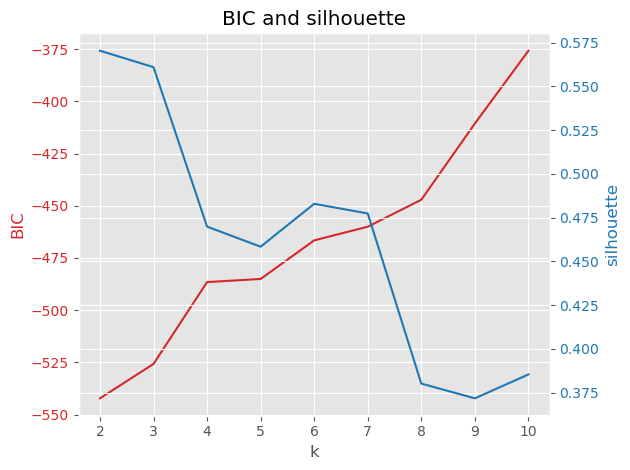

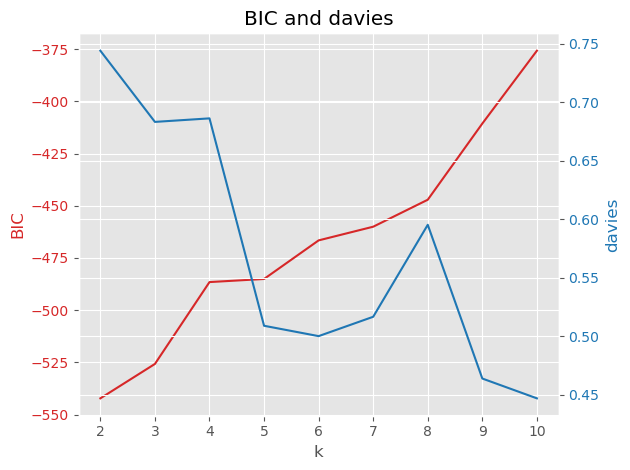

In [16]:
# calculate different types of scores to decide on number of clusters
def get_km(k, X):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X)
    return km

def get_bic(k, X):
    gmm = GaussianMixture(n_components=k, init_params='kmeans', random_state=1)
    gmm.fit(X)
    return gmm.bic(X)

def get_score(k, X):
    km = get_km(k, X)
    y_pred = km.predict(X)
    bic = get_bic(k, X)
    sil = silhouette_score(X, y_pred)
    db = davies_bouldin_score(X, y_pred)
    return k, bic, sil, db

scores_df = pd.DataFrame([get_score(k, normal_2018) for k in range(2, 11)],
                  columns=['k', 'BIC', 'silhouette','davies'])

plt.style.use('ggplot')

def plot_compare(df, y1, y2, x, fig, ax1):
    ax1.plot(df[x], df[y1], color='tab:red')
    ax1.set_title(f'{y1} and {y2}')
    ax1.set_xlabel(x)
    ax1.set_ylabel(y1, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.plot(df[x], df[y2], color='tab:blue')
    ax2.set_ylabel(y2, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

def plot_result(df, y1, y2, x):
    fig, axes = plt.subplots(1)
    plot_compare(df, y1, y2, x, fig, axes)
    plt.tight_layout()
    
plot_result(scores_df, 'BIC', 'silhouette', 'k')
plot_result(scores_df, 'BIC', 'davies', 'k')

# BIC: lower is better
# silhouette: higher is better
# davies: lower is better

To interpret the test results it is crucial to know that for the BIC score, the lower is number is better. For the Silhouette score, the higher the number is better and for Davies the lower is better. From the plots it can be seen that k = 3 and k = 4 clusters are the candidates that result in good scores.

Another factor that may be taken into account for determining the number of clusters is the problem definition. Does a specific number of clusters align better with the natural grouping of the data, making it more interpretable in the context of our research question? In our case k = 3 or k = 4 would both be interpretable, since we are looking at three distinct modes (car, public transport and active modes), plus the other mode category that could make k = 4 suitable.

Combining all these results we have decided to choose k = 4 clusters.

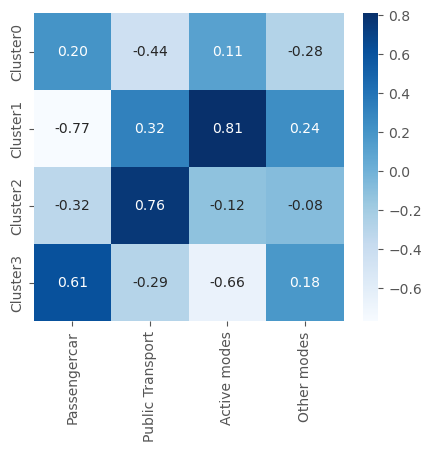

In [17]:
# apply k-means clustering technique
kmeans = KMeans(n_clusters=4, random_state=1).fit(normal_2018)

# obtain clusters and add label to data
normal_2018['cluster'] = kmeans.labels_

# make binary columns in data for each cluster 
normal_2018['Cluster0'] = np.where(normal_2018['cluster'] != 0, 0, 1)
normal_2018['Cluster1'] = np.where(normal_2018['cluster'] != 1, 0, 1)
normal_2018['Cluster2'] = np.where(normal_2018['cluster'] != 2, 0, 1)
normal_2018['Cluster3'] = np.where(normal_2018['cluster'] != 3, 0, 1)

# make cluster vs. mode correlation plot to see which modes are most present in each cluster
fig, axes = plt.subplots(figsize = (5,4))
correlation_table = normal_2018.corr()
corr2 = correlation_table.drop(correlation_table.index[range(5)])
corr3 = corr2.drop(columns=corr2.columns[4:])
corr_m = sns.heatmap(round(corr3, 2), annot=True, cmap='Blues', ax=axes, fmt='.2f')

Still need to elaborate on these results here. Something about the different clusters and which modes correspond most, as well as make some nice figures showing the various personal characteristics in every cluster. Afterwards we can discuss the results.

# Conlusion
We still need to write something here.

## Limitations and recommendations
We still need to write something here.

# References

[1] NS wil voorstel spitsheffing beperken tot â‚¬2,50 per rit (businessinsider.nl)(https://www.businessinsider.nl/ns-wil-voorstel-spitsheffing-beperken-tot-e250-per-rit-veel-verzet-in-tweede-kamer/)

[2] StatLine - Mobiliteit; per persoon, persoonskenmerken, vervoerwijzen en regio's (cbs.nl) (https://opendata.cbs.nl/statline/#/CBS/nl/dataset/84709NED/table?ts=1696241475558)